# Similarity Analysis of Conte Core Freesurfer QC Editing

Inter-editor comparisons for brain mask, white matter mask and control point placement

Author : Mike Tyszka  
Place  : Caltech  
Dates  : 2020-05-04 JMT From scratch  
         2020-06-05 JMT Update for final training set  
         2020-06-15 JMT Update for new folder structure

### Imports

In [2]:
import os
import numpy as np
import pandas as pd
import shutil
import nibabel as nib
import seaborn as sns

from datetime import datetime
from datetime import datetime

from skimage.feature import canny
from skimage.filters import sobel
from skimage.color import gray2rgb

%matplotlib inline
import matplotlib.pyplot as plt

### Load Results

In [3]:
# Scan assignments directory for editors, subjects and results
root_dir = os.path.join('..', '..')
fs6_src_dir = os.path.join(root_dir, 'Source')
fs6_edit_dir = os.path.join(root_dir, 'Edits')

# Subject-Editor list
edited_list = []

for editor in os.listdir(fs6_edit_dir):

    for subject in os.listdir(os.path.join(fs6_edit_dir, editor)):
        
        if 'sub-' in subject:
        
            # Find unedited FS recon in main repository
            subj_dir = os.path.join(fs6_src_dir, subject)

            if not os.path.isdir(subj_dir):
                
                print('* {} not found amongst unedited subjects - skipping'.format(subject))
            
            else:
                
                edited_list.append({'Subject':subject, 'Editor':editor})
                
# Convert to dataframe
edited = pd.DataFrame(edited_list)

### Utility Functions

#### Color MIP

In [4]:
def colorize(img_gray, rgb):
    
    # Normalize intensity range
    max_i = np.max(img_gray)
    if max_i > 0.0:
        img_gray = img_gray / max_i

    # Extract RGB channels
    r, g, b = rgb
    
    # Create RGBA template from grayscale image
    nx, ny = img_gray.shape
    img_rgba = np.zeros([nx, ny, 4])
        
    # Refill RGBA image
    # RGB channels set to palette color
    # Alph channel mapped to grayscale
    img_rgba[:, :, 0] = r
    img_rgba[:, :, 1] = g
    img_rgba[:, :, 2] = b
    img_rgba[:, :, 3] = img_gray
    
    return img_rgba

def composite(rgba_list):
    
    # Axes: (editor, x, y, RGBA)
    rgba_array = np.array(rgba_list)
    
    # Get image dimensions
    ne, nx, ny, nc = rgba_array.shape
    
    # Separate R, G, B, A
    r = rgba_array[:, :, :, 0]
    g = rgba_array[:, :, :, 1]
    b = rgba_array[:, :, :, 2]
    a = rgba_array[:, :, :, 3]
    
    # Pre-multiply RGB by original alpha
    ra = r * a
    ga = g * a
    ba = b * a
    
    # Compute final alpha
    a_f = np.sum(a, axis=0)
    
    # Addition compositing function
    r_c = np.sum(ra, axis=0)
    g_c = np.sum(ga, axis=0)
    b_c = np.sum(ba, axis=0)
    
    # Clip channels to range 0-1
    r_f = np.clip(r_c, 0, 1)
    g_f = np.clip(g_c, 0, 1)
    b_f = np.clip(b_c, 0, 1)
    a_f = np.clip(a_f, 0, 1)
    
    # Create final RGB composite
    comp_rgb = np.zeros([nx, ny, 3])
    comp_rgb[:, :, 0] = r_f * a_f
    comp_rgb[:, :, 1] = g_f * a_f
    comp_rgb[:, :, 2] = b_f * a_f

    return comp_rgb

def color_key(editors, palette, ax):
    
    from matplotlib.patches import Patch

    legend_elements = []
    
    for ec, editor in enumerate(editors):
        legend_elements.append(Patch(facecolor=palette[ec], label=editor))

    # Create the legend
    ax.legend(handles=legend_elements, loc='center left')
    plt.axis('off')
    
def bg_edges(bg):
    
    # Binarize background
    mask = np.array(bg > 0, dtype='int')
    
    # MIP and edge detect
    bg_xy = sobel(np.max(mask, axis=2))
    bg_xz = sobel(np.max(mask, axis=1))
    bg_yz = sobel(np.max(mask, axis=0))
    
    # Normalize to [0, 1]
    bg_xy = (bg_xy + 1e-31) / (np.max(bg_xy) + 1e-31)
    bg_xz = (bg_xz + 1e-31) / (np.max(bg_xz) + 1e-31)
    bg_yz = (bg_yz + 1e-31) / (np.max(bg_yz) + 1e-31)
    
    bg_xy = gray2rgb(bg_xy)
    bg_xz = gray2rgb(bg_xz)
    bg_yz = gray2rgb(bg_yz)
    
    return bg_xy, bg_xz, bg_yz

def color_mip(editor_img_list, editors, bg, title=''):
        
    # Editor color palette
    n_editors = len(editors)
    palette = sns.color_palette("hls", n_editors)
    
    # Brain mask edges (RGB)
    bg_xy, bg_xz, bg_yz = bg_edges(bg)
    
    # Loop over editors creating colorized MIPs
    mip_rgba_xy_list = []
    mip_rgba_xz_list = []
    mip_rgba_yz_list = []
    
    for ec, editor_img in enumerate(editor_img_list):
        
        # MIP of editor labeling differences from original
        mip_gray_xye = np.max(editor_img, axis=2)
        mip_gray_xze = np.max(editor_img, axis=1)
        mip_gray_yze = np.max(editor_img, axis=0)
        
        # Colorize grayscale MIP to RGBA using palette color for this editor
        rgb = palette[ec]
        mip_rgba_xye = colorize(mip_gray_xye, rgb)
        mip_rgba_xze = colorize(mip_gray_xze, rgb)
        mip_rgba_yze = colorize(mip_gray_yze, rgb)
        
        mip_rgba_xy_list.append(mip_rgba_xye)
        mip_rgba_xz_list.append(mip_rgba_xze)
        mip_rgba_yz_list.append(mip_rgba_yze)
    
    # Alpha-composited RGB projections
    comp_rgb_xy = composite(mip_rgba_xy_list)
    comp_rgb_xz = composite(mip_rgba_xz_list)
    comp_rgb_yz = composite(mip_rgba_yz_list)
    
    # Add brain mask edges
    comp_rgb_xy = np.clip(comp_rgb_xy + bg_xy, 0, 1)
    comp_rgb_xz = np.clip(comp_rgb_xz + bg_xz, 0, 1)
    comp_rgb_yz = np.clip(comp_rgb_yz + bg_yz, 0, 1)
    
    # Adjust orientations to match CP axes
    comp_rgb_xy = np.flip(np.swapaxes(comp_rgb_xy, 0, 1), 0)
    comp_rgb_xz = np.swapaxes(comp_rgb_xz, 0, 1)
    comp_rgb_yz = np.flip(comp_rgb_yz, 0)
    
    # Plot composited images   
    fig, axs = plt.subplots(1,4, figsize=(20,6))
    
    axs[0].imshow(comp_rgb_xy, origin='lower')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('z')
    axs[0].set_title(title + ' - Coronal')
    
    axs[1].imshow(comp_rgb_xz, origin='lower')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    axs[1].set_title(title + ' - Axial')
    
    axs[2].imshow(comp_rgb_yz, origin='lower')
    axs[2].set_xlabel('y')
    axs[2].set_ylabel('z')
    axs[2].set_title(title + ' - Sagittal')
    
    color_key(editors, palette, axs[3])
    
    plt.show()

#### Project Control Points

In [5]:
def project_cps(editor_cps_list, editors, bg, title=None):
    """
    Empirical point domain:
    x : [-128, 127]
    y : [-104, 153]
    z : [-132, 127]
    
    Mapping control point (x', y', z') to voxel space (x, y, z)
    x = 128 - x' (note flip)
    y = y' + 104
    z = z' + 132
    
    # Mapping of voxel (x, y, z) to anatomic axes (LSA):
    x : R > L
    y : I > S
    z : P > A

    """
    
    # Editor color palette
    n_editors = len(editors)
    palette = sns.color_palette("hls", n_editors)
    
    # Brain mask edge projections (RGB)
    bg_xy, bg_xz, bg_yz = bg_edges(bg)
    
    # Adjust orientations to match CP axes
    cp_bg_xz = np.flip(np.swapaxes(bg_xy, 0, 1), 0)
    cp_bg_xy = np.swapaxes(bg_xz, 0, 1)
    cp_bg_yz = np.flip(bg_yz, 0)
    
    # Control point components in voxel space
    if len(editor_cps_list) > 0:
        cps_all = np.concatenate(editor_cps_list)
        x = 128 - cps_all[:, 0]
        y = cps_all[:, 1] + 104
        z = cps_all[:, 2] + 132
    else:
        x = np.nan
        y = np.nan
        z = np.nan
    
    fig, axs = plt.subplots(1,4, figsize=(20,6))
    
    axs[0].imshow(cp_bg_xz)
    axs[0].scatter(x, z)
    axs[0].set_xlim((0, 255))
    axs[0].set_ylim((0, 255))
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('z')
    axs[0].set_title(title + ' - Coronal')
    
    axs[1].imshow(cp_bg_xy)
    axs[1].scatter(x, y)
    axs[1].set_xlim((0, 255))
    axs[1].set_ylim((0, 255))
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    axs[1].set_title(title + ' - Axial')
    
    axs[2].imshow(cp_bg_yz)
    axs[2].scatter(y, z)
    axs[2].set_xlim((0, 255))
    axs[2].set_ylim((0, 255))
    axs[2].set_xlabel('y')
    axs[2].set_ylabel('z')
    axs[2].set_title(title + ' - Sagittal')
    
    color_key(editors, palette, axs[3])
    
    plt.show()

#### Load Control Points

In [6]:
def load_cps(fname):
    """
    Example control.dat file:

    -35 16 -9
    -35 15 -9
    -36 14 -9
    -63 -38 15
    -63 -40 18
    info
    numpoints 5
    useRealRAS 0

    """

    cps = []

    try:
        with open(fname, 'r') as fd:
            for line in fd:
                line = line.strip()
                vals = line.split(' ')
                if len(vals) == 3:
                    cps.append(vals)
    except IOError:
        print('* Problem loading {}'.format(fname))
    except UnicodeDecodeError:
        print('* Problem decoding {}'.format(fname))

    return np.array(cps, dtype=np.float)

### Report Stats and Figures

--------------------------------
Time Stamp : 2020/06/15 12:07:18
--------------------------------

--------------------------------
Subject sub-CC0016_core1
--------------------------------

     Editor  BM Voxels  WM Voxels  BFS Voxels  WM CPs
0  WenyingZ        790         30           0       9
1     AndyL       1324        183           0      36
2     AyseE        705          0           0       7
3    DavidK        848          0           0      15
4    DoritK       2638        402           0      17
5     MikeT       1465        258           0       7
6   StevenL        304          0           0       2
7    TessaR        628         72           0      39



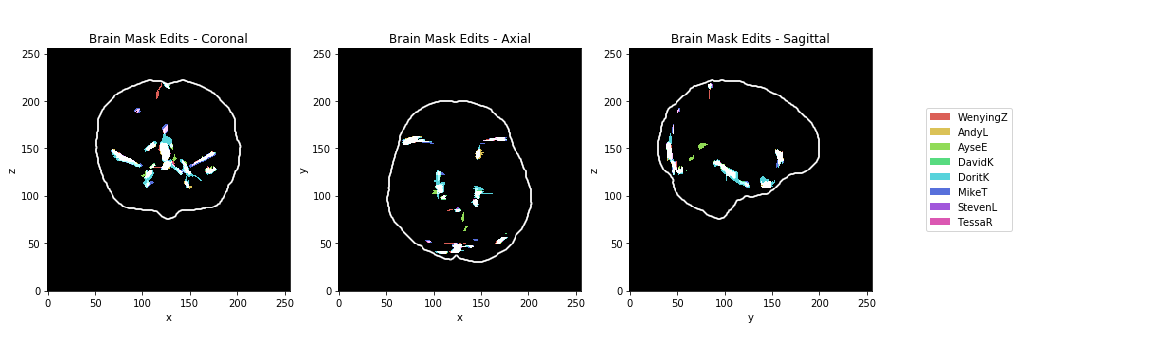

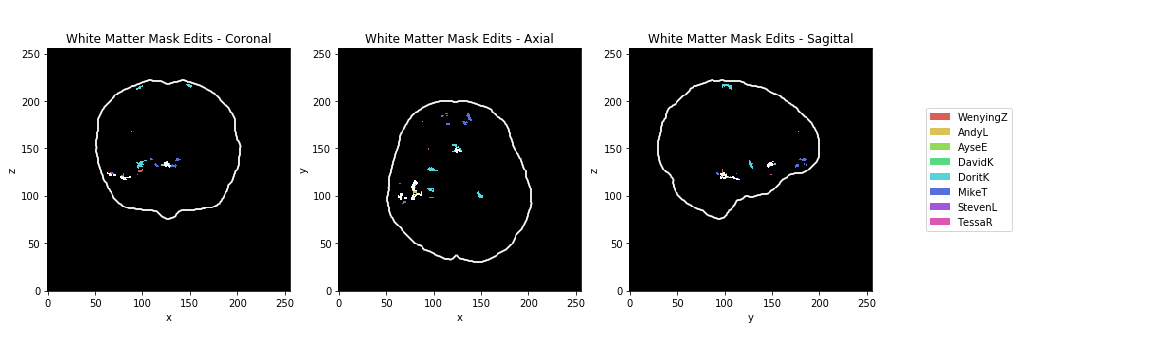

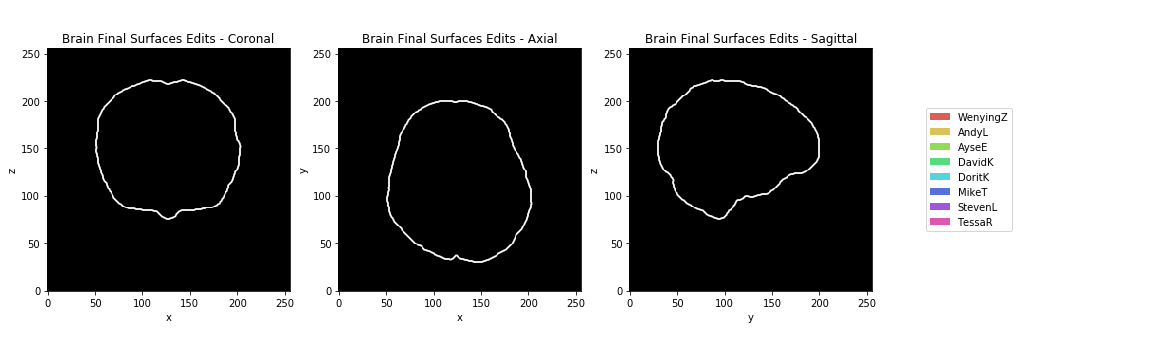

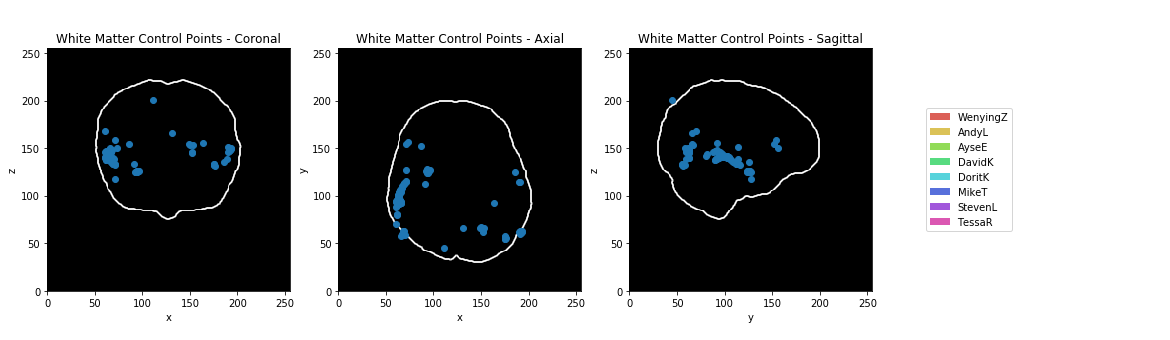

--------------------------------
Subject sub-CC0058_core1
--------------------------------

     Editor  BM Voxels  WM Voxels  BFS Voxels  WM CPs
0  WenyingZ        692          0           0       8
1     AndyL       1167        117           0       0
2     AyseE        602         84           0       4
3    DavidK        577         57           0       3
4    DoritK       3312        362           0       0
5     MikeT       8636        963           0       0
6   StevenL        682          3           0       0
7    TessaR        729        160           0       0



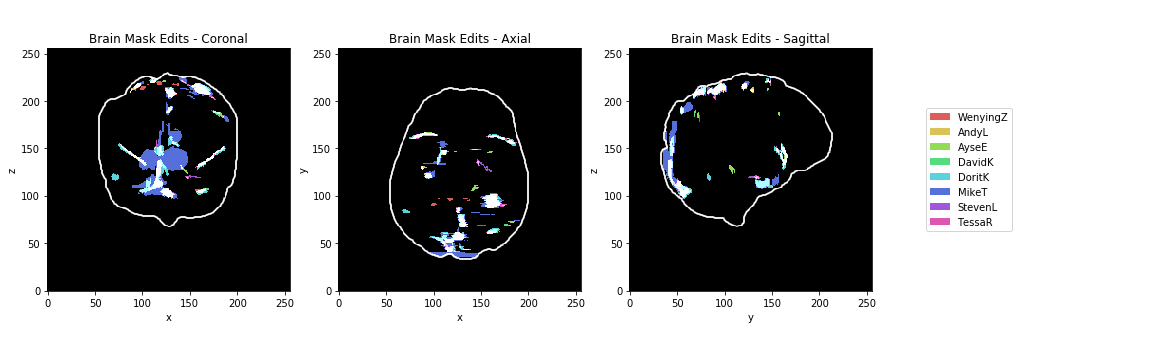

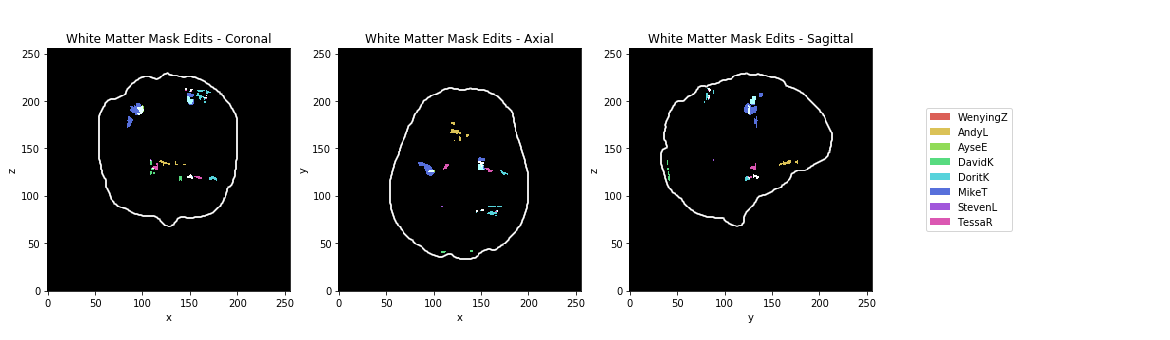

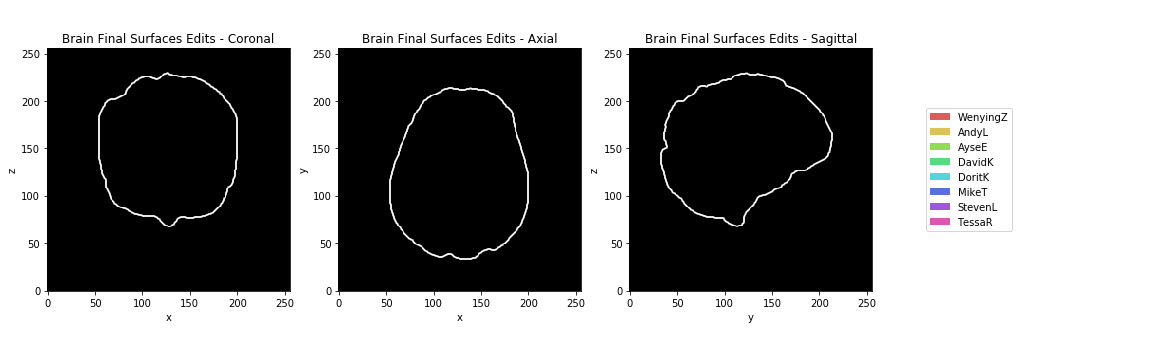

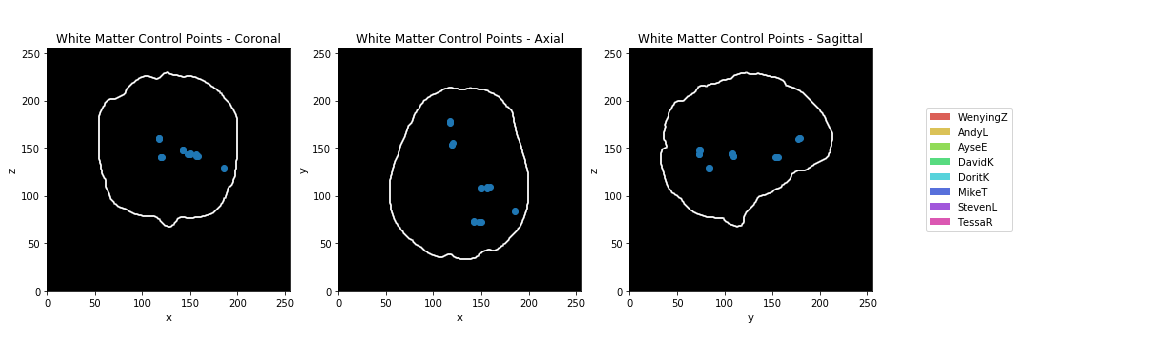

--------------------------------
Subject sub-CC0076_core1
--------------------------------

     Editor  BM Voxels  WM Voxels  BFS Voxels  WM CPs
0  WenyingZ       1497          0           0       2
1     AndyL       2145         96           0      33
2     AyseE        573          0           0       1
3    DavidK        610          0           0       4
4    DoritK       2924         52           0      20
5     MikeT       4279         65           0      26
6   StevenL        702          0           0       0
7    TessaR        633         16           0      52



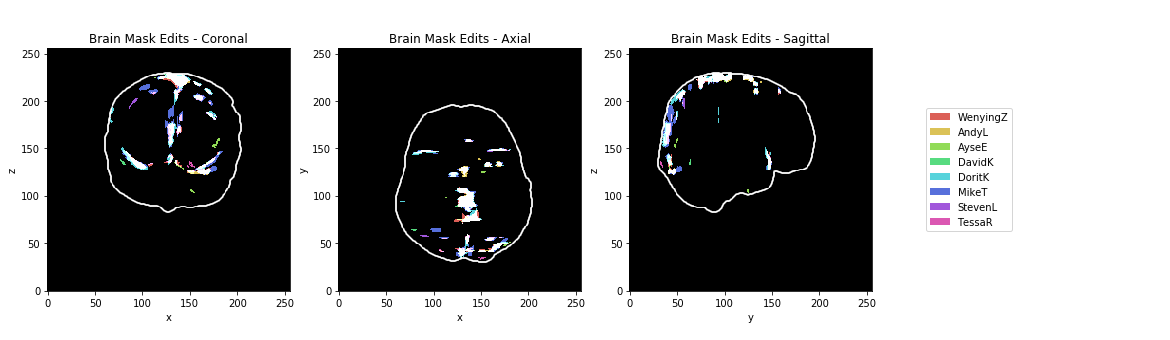

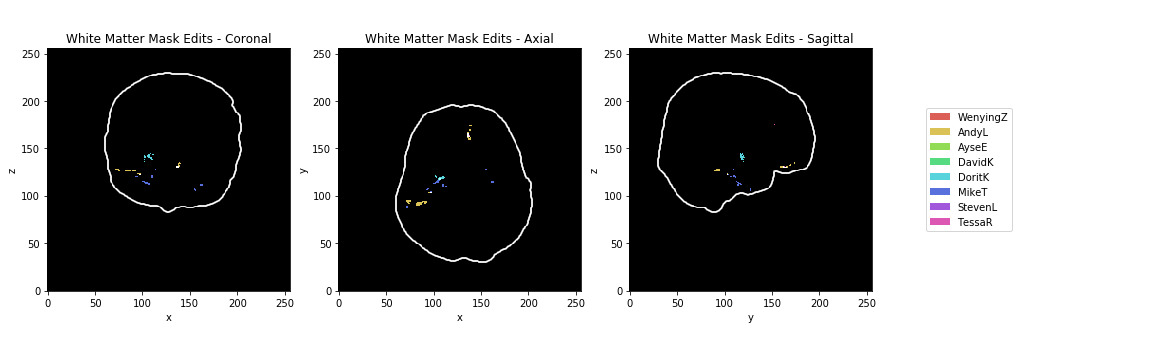

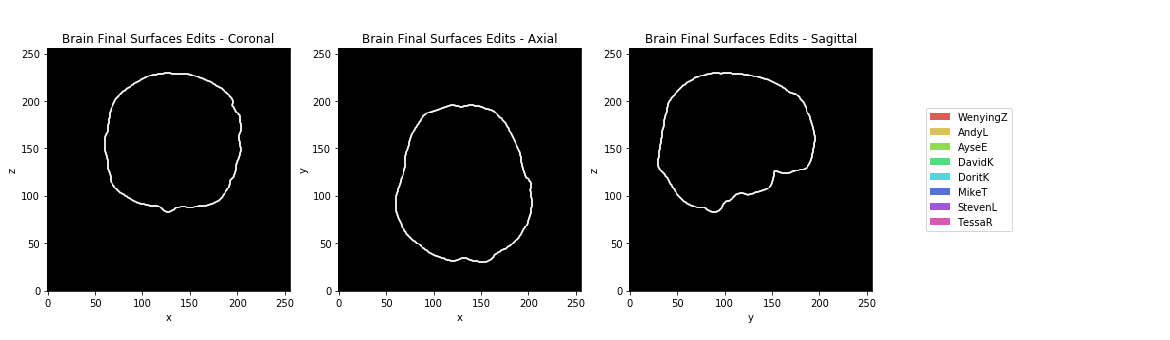

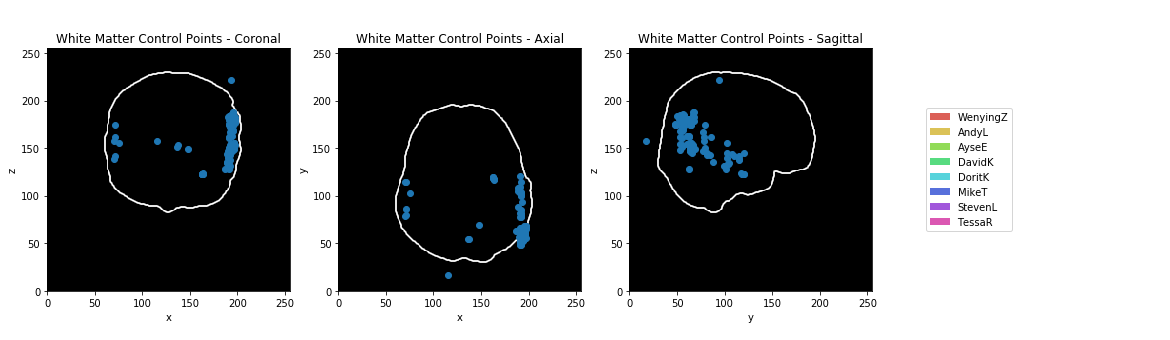

--------------------------------
Subject sub-CC0092_core1
--------------------------------

     Editor  BM Voxels  WM Voxels  BFS Voxels  WM CPs
0  WenyingZ        371        230           0      10
1     AndyL        363         12           0       1
2     AyseE       1283        152           0       8
3    DavidK        548         21           0       1
4    DoritK       1522       1181           0       0
5     MikeT       2414       1563           0       3
6   StevenL        359         12           0       0
7    TessaR        853        644           0       3



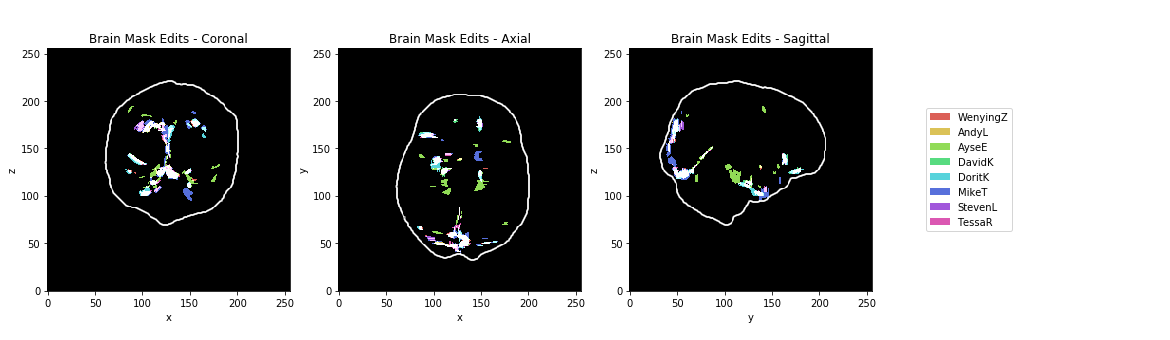

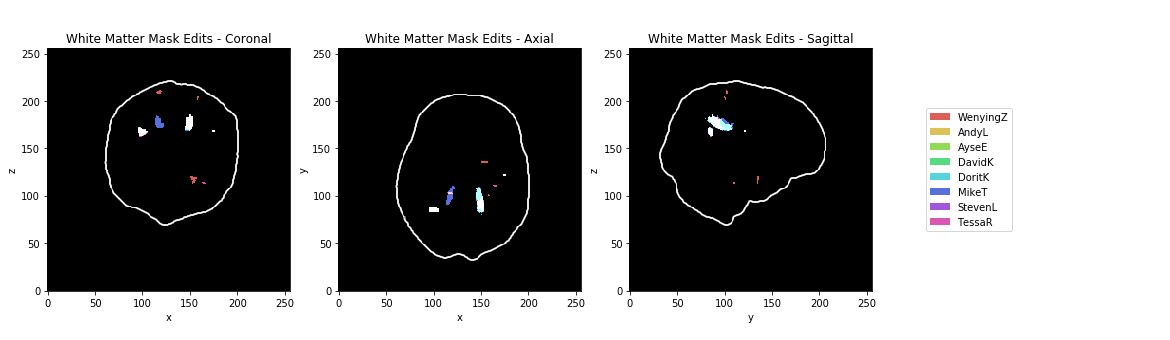

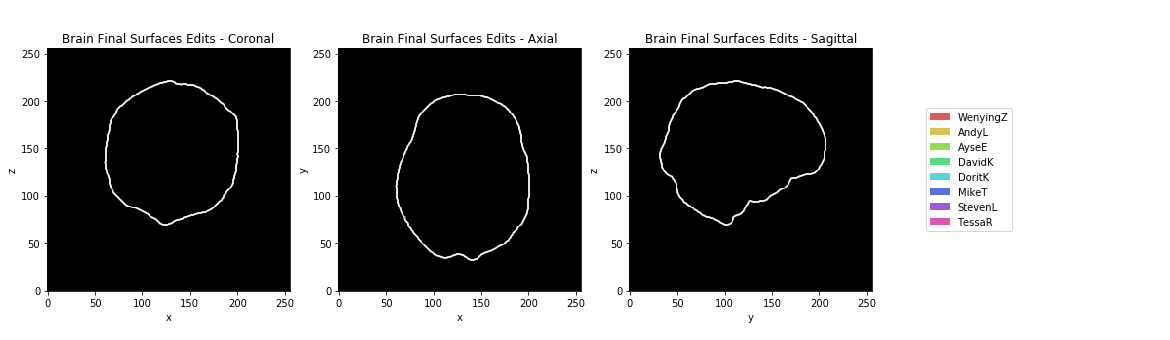

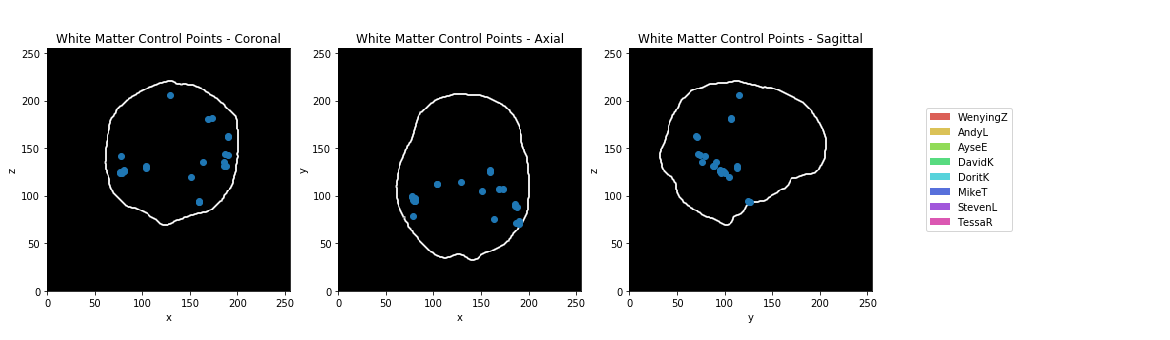

--------------------------------
Subject sub-CC0106_core2
--------------------------------

     Editor  BM Voxels  WM Voxels  BFS Voxels  WM CPs
0  WenyingZ        767        199           0       0
1     AndyL        713        423           0       0
2     AyseE        796          0           0       9
3    DavidK        264         46          24       3
4    DoritK        522       1431           0      13
5     MikeT       1411         40           0       0
6   StevenL        203          0           0       0
7    TessaR         85          0           0       0



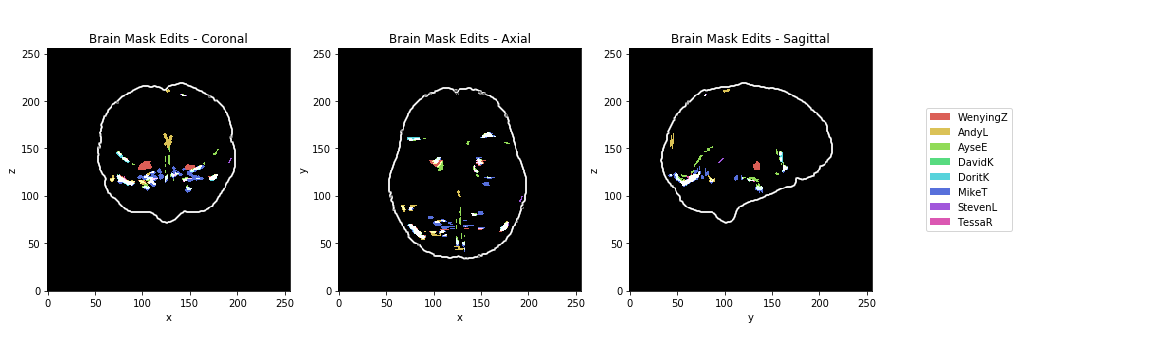

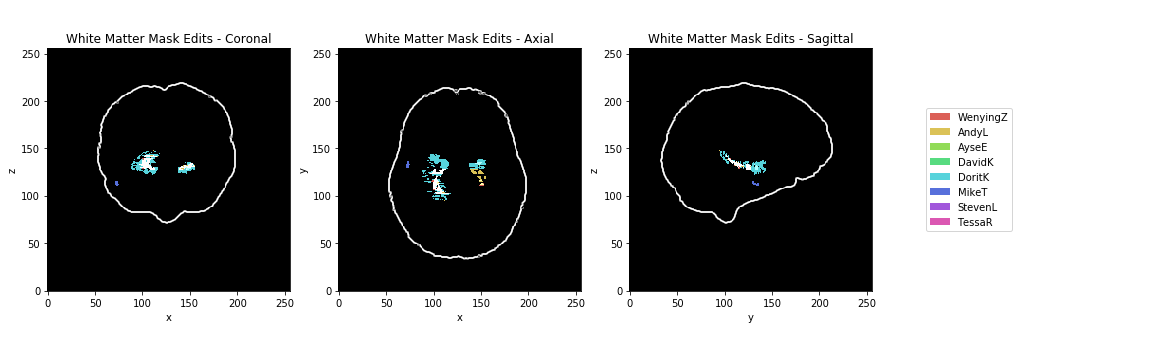

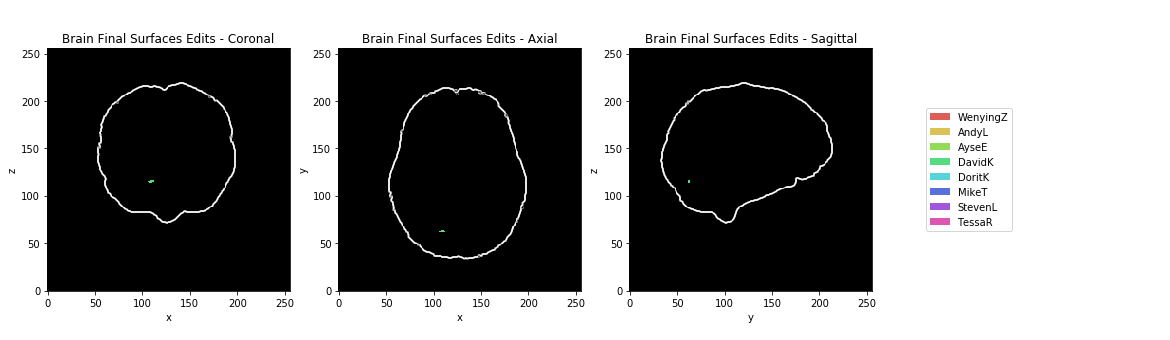

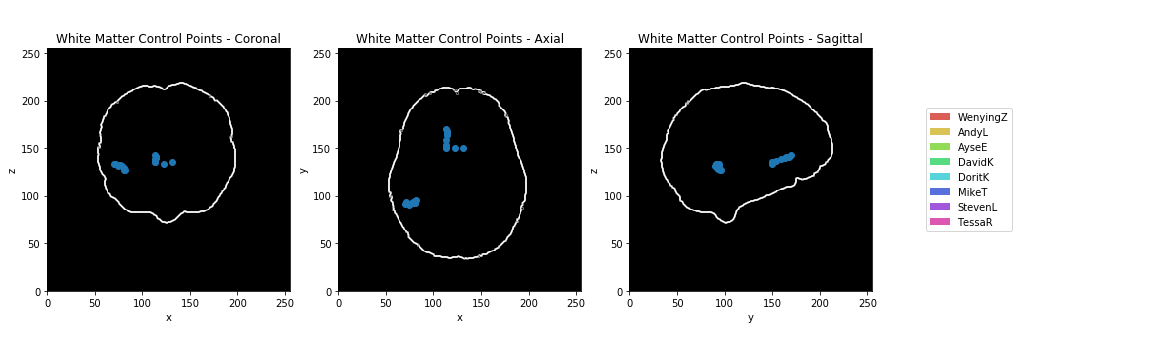

--------------------------------
Subject sub-CC0117_core1
--------------------------------

     Editor  BM Voxels  WM Voxels  BFS Voxels  WM CPs
0  WenyingZ          0          8        1149       3
1     AndyL       6283          0        4897       0
2     AyseE       4013          4         528       7
3    DavidK       4655          0         244       0
4    DoritK      12948        302        1316       0
5     MikeT       3468        294         644       0
6   StevenL       2408         22           0       0
7    TessaR        971          0         194       0



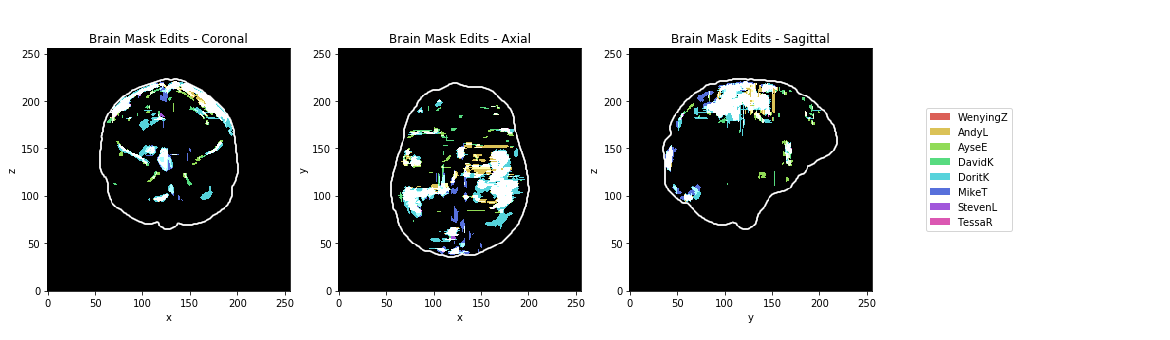

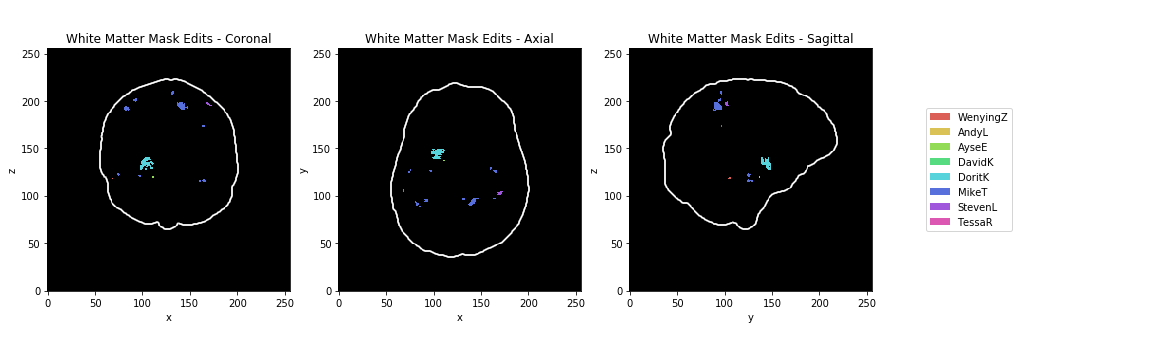

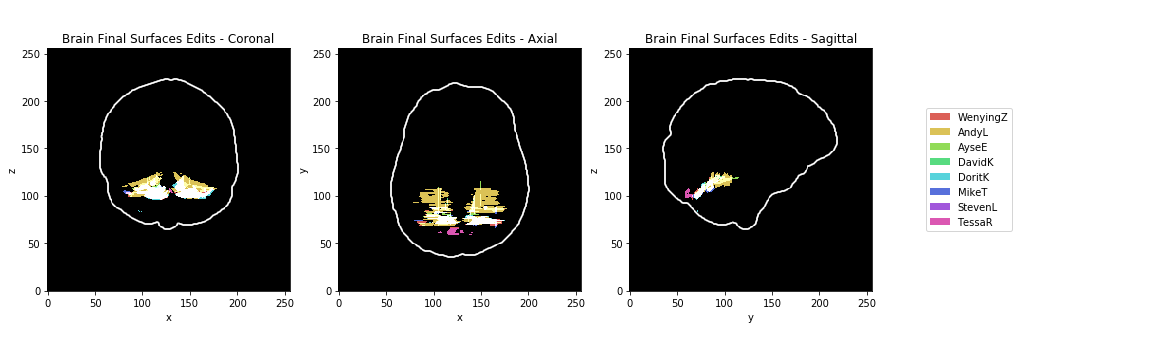

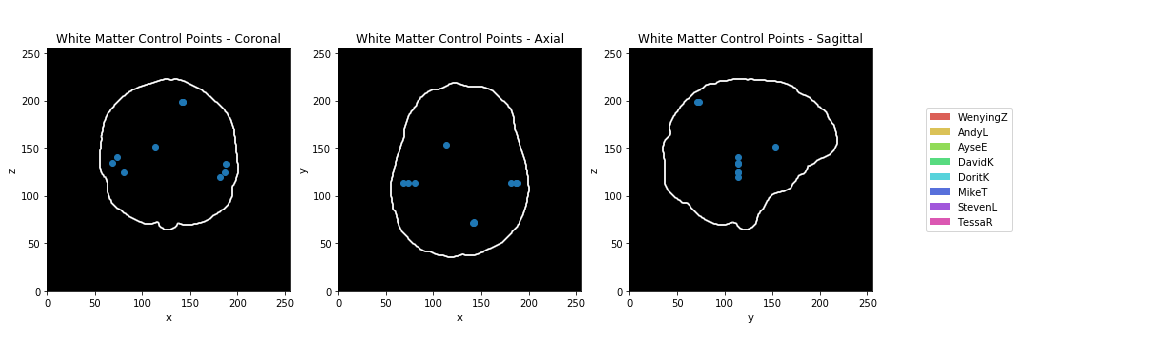

--------------------------------
Subject sub-CC0143_core2
--------------------------------

     Editor  BM Voxels  WM Voxels  BFS Voxels  WM CPs
0  WenyingZ        328          0           0       0
1     AndyL        858          0           0       9
2     AyseE       1229          0           0       9
3    DavidK        402          0          29       2
4    DoritK       1783          0           0      10
5     MikeT        529          0           0       0
6   StevenL         48          0           0       0
7    TessaR        154          0           0       0



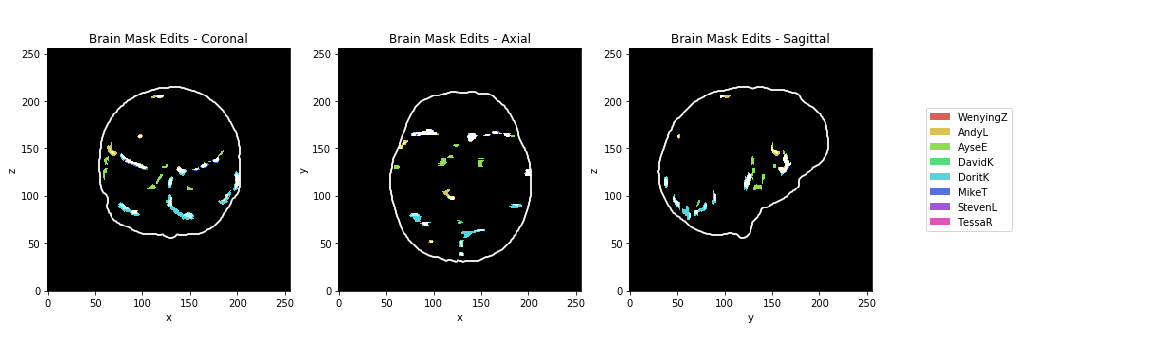

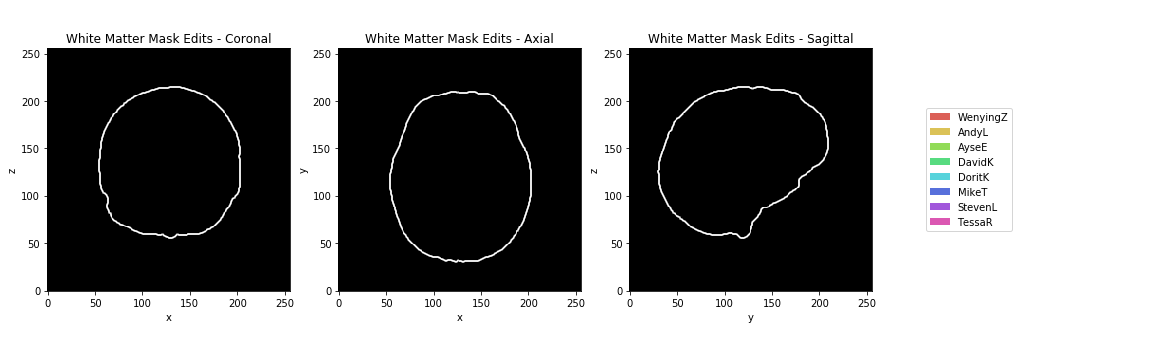

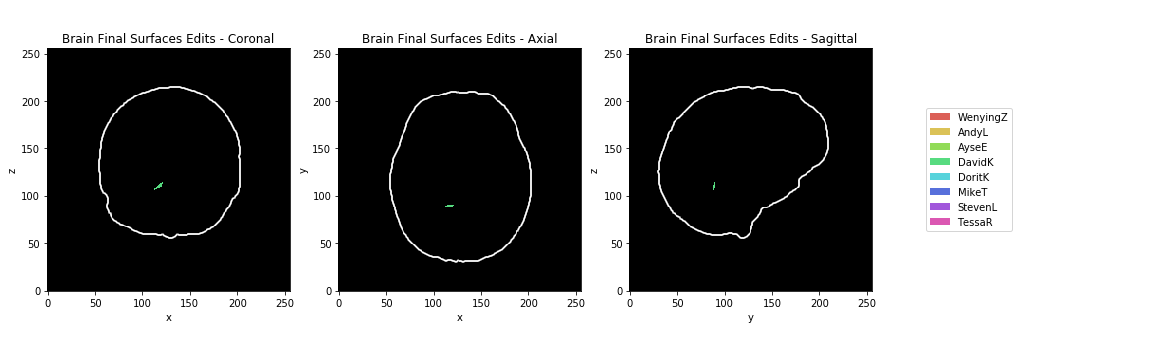

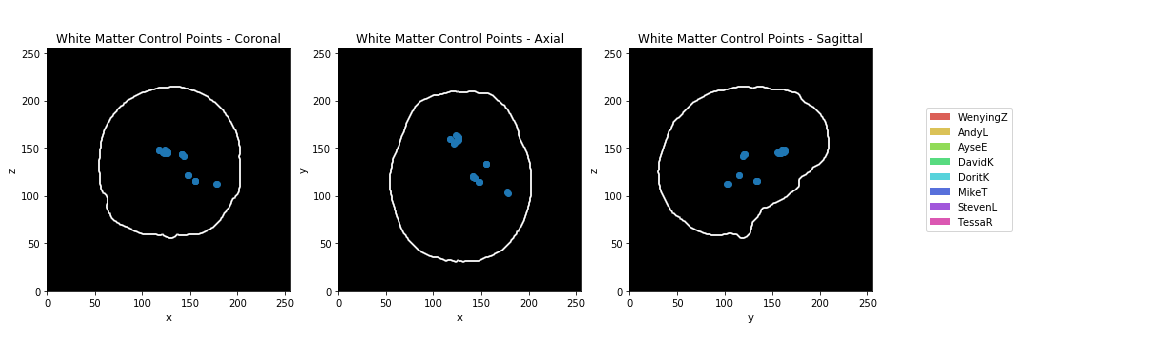

--------------------------------
Subject sub-CC0151_core2
--------------------------------

     Editor  BM Voxels  WM Voxels  BFS Voxels  WM CPs
0  WenyingZ       1176          0           0       0
1     AndyL        839          0           0      10
2     AyseE       1170          0           0       0
3    DavidK        398          0          46       2
4    DoritK       2400        135           0       0
5     MikeT       1324          0           0       0
6   StevenL        144          0           0       0
7    TessaR        432          0           0       0



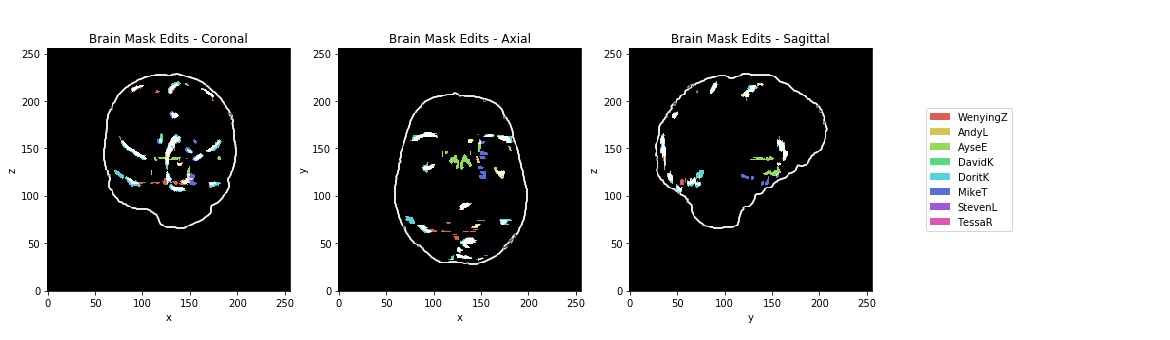

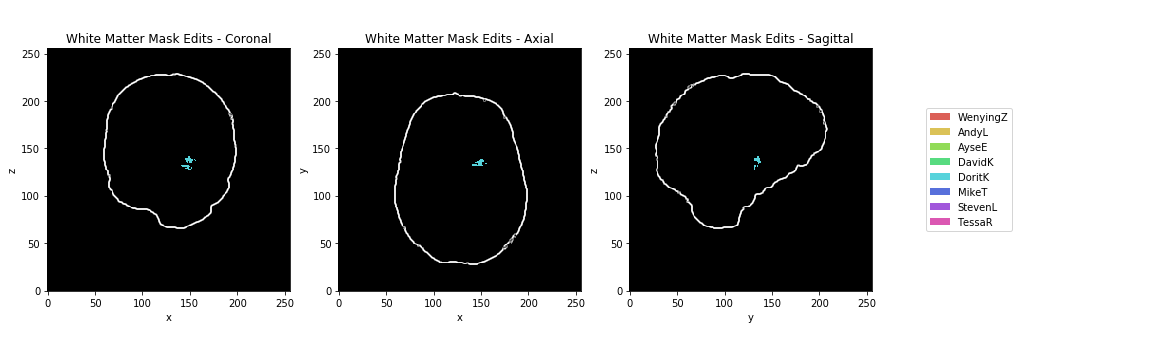

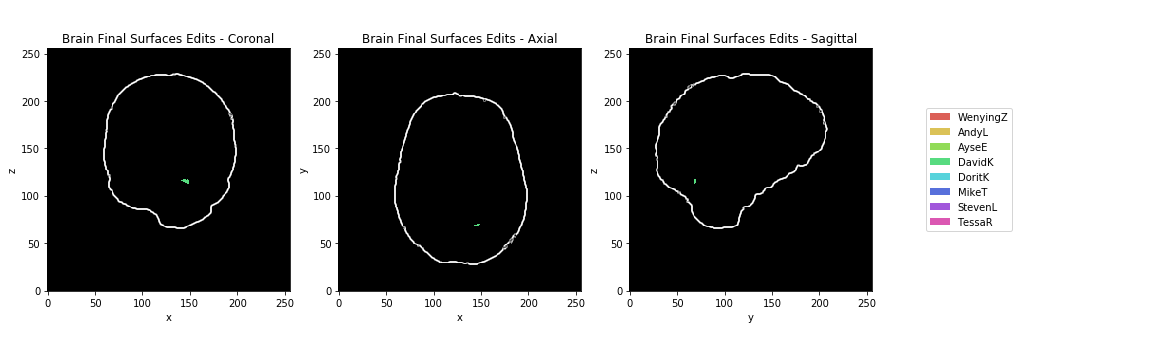

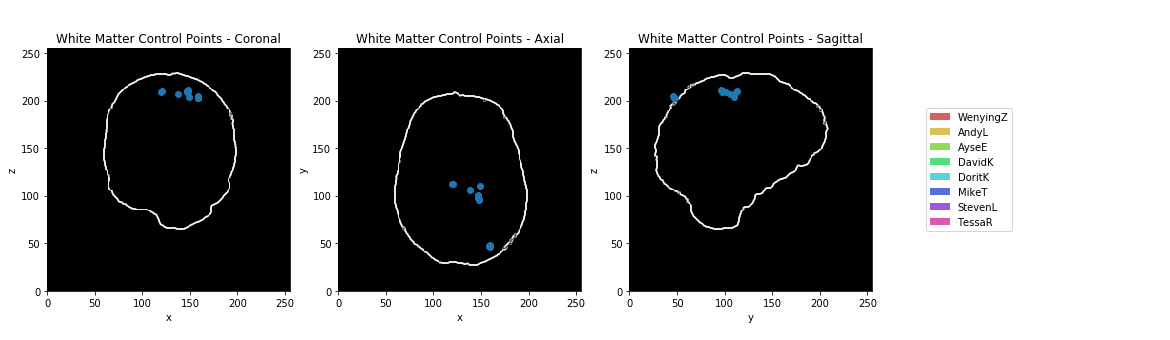

--------------------------------
Subject sub-CC0155_core2
--------------------------------

     Editor  BM Voxels  WM Voxels  BFS Voxels  WM CPs
0  WenyingZ        301          0           0       0
1     AndyL        298          0           0       2
2     AyseE        700          0          57       0
3    DavidK        180          0           0       0
4    DoritK        782          0           0       0
5     MikeT        345          0           0       0
6   StevenL         28          0           0       0
7    TessaR        195          0           0       0



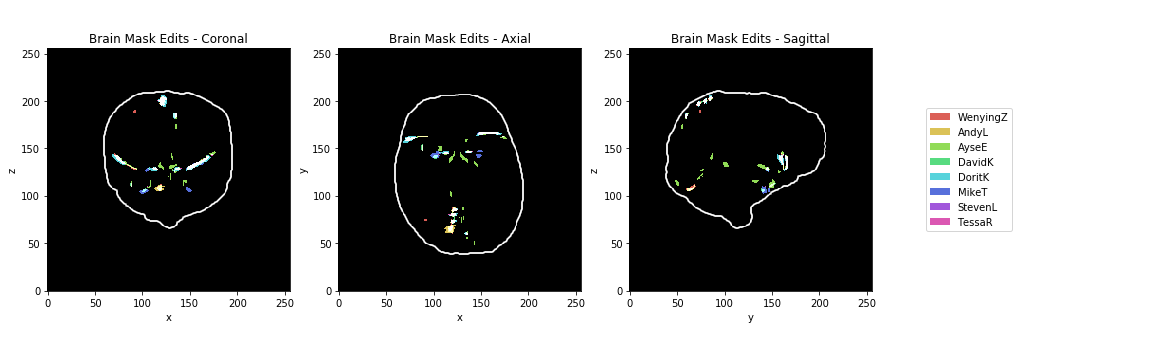

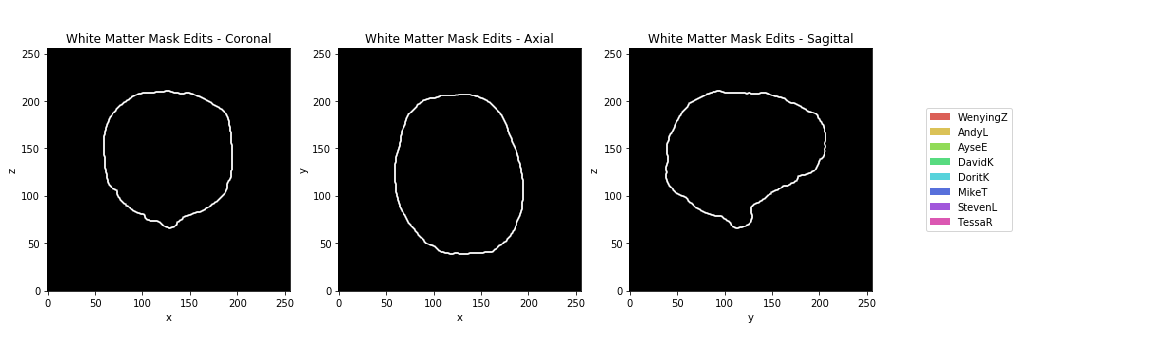

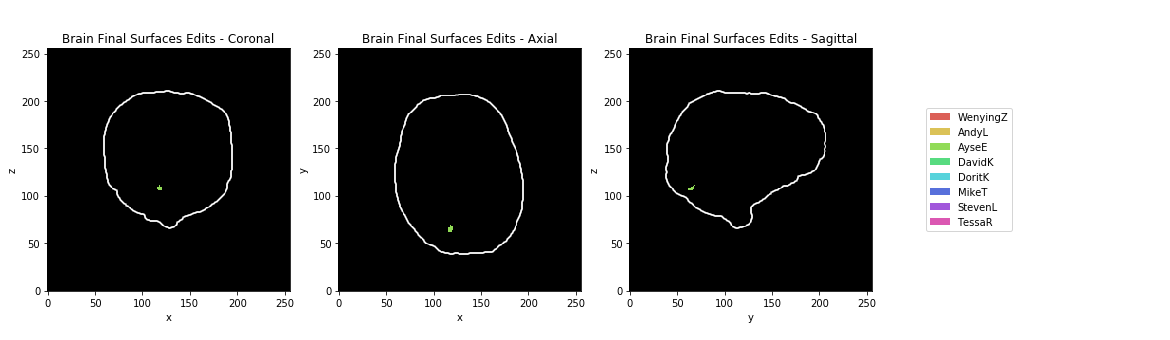

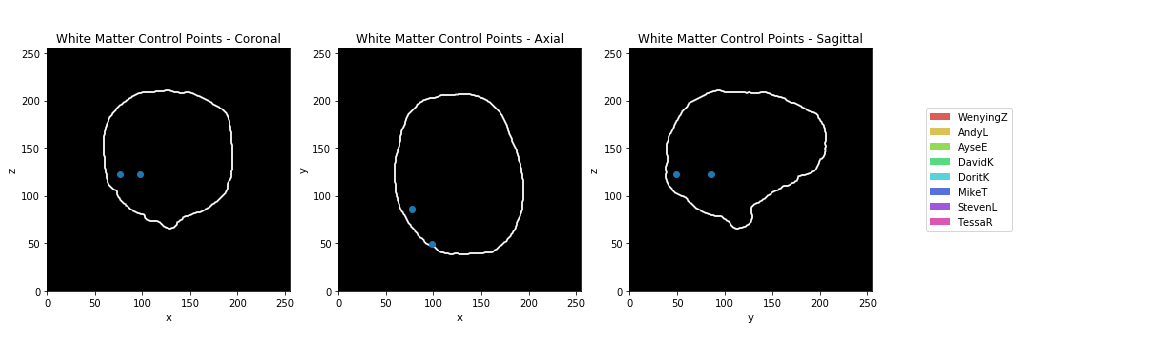

--------------------------------
Subject sub-CC0177_core2
--------------------------------

     Editor  BM Voxels  WM Voxels  BFS Voxels  WM CPs
0  WenyingZ       1300          0           0       0
1     AndyL          0          0           0       0
2     AyseE       1638          0           0       2
3    DavidK        907          0           0       0
4    DoritK       4642          0           0       0
5     MikeT        986          0           0       0
6   StevenL        643          0           0       0
7    TessaR        171          0           0       0



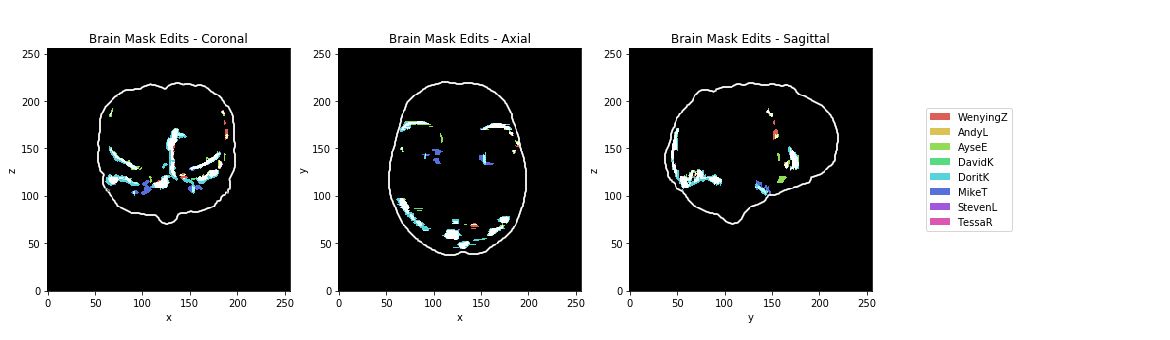

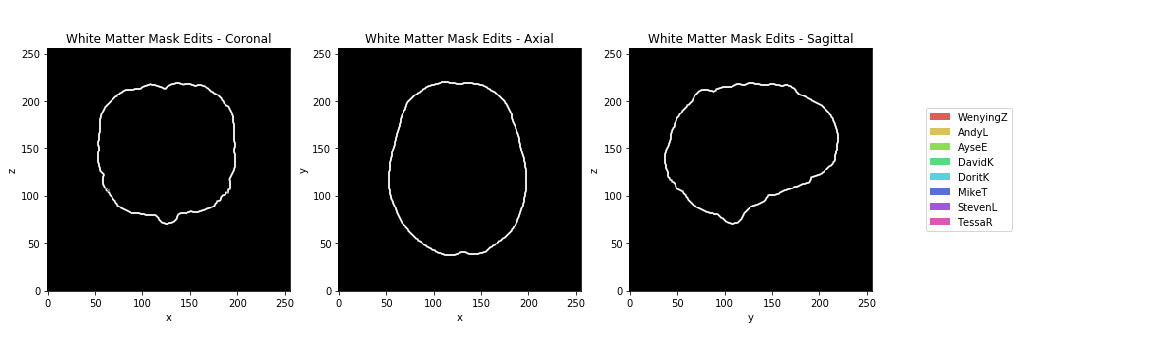

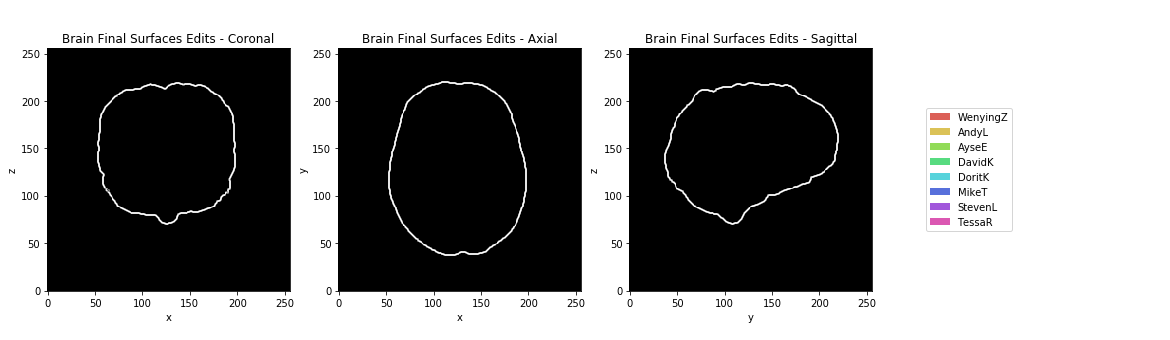

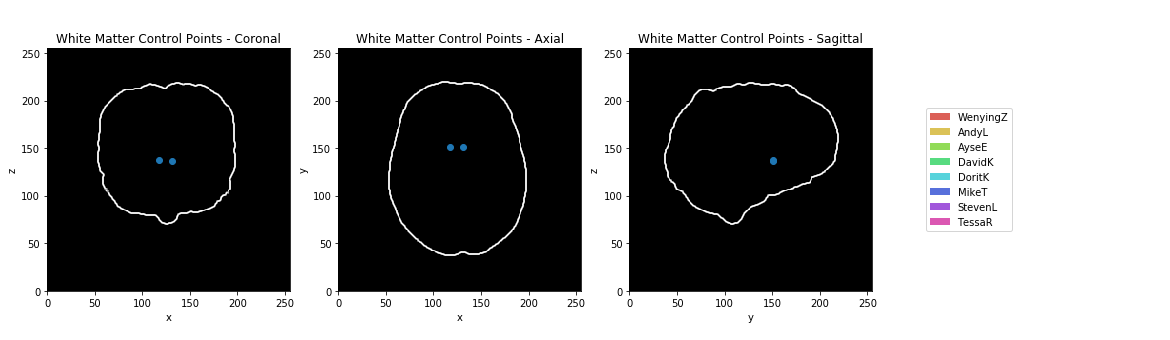

In [7]:
# Loop over each unique edited subject
subjects = np.unique(edited['Subject'])

# Decoration
dashes = '-' * 32

# Splash text
timestamp = datetime.now().strftime("%Y/%m/%d %H:%M:%S")
print(dashes)
print('Time Stamp : {}'.format(timestamp))
print(dashes)
print('')

for subject in subjects:
    
    print(dashes)
    print('Subject {}'.format(subject))
    print(dashes)
    print('')
    
    # Load brain and WM masks for this subject
    mri_dir = os.path.join(fs6_src_dir, subject, 'mri')
    
    bm_orig_mgh = nib.load(os.path.join(mri_dir, 'brainmask.mgz'))
    bm_orig = bm_orig_mgh.get_fdata()
    
    wm_orig_mgh = nib.load(os.path.join(mri_dir, 'wm.mgz'))
    wm_orig = wm_orig_mgh.get_fdata()
    
    bfs_orig_mgh = nib.load(os.path.join(mri_dir, 'brain.finalsurfs.mgz'))
    bfs_orig = bfs_orig_mgh.get_fdata()

    # Find editors for this subject
    editors = edited[edited['Subject'] == subject]['Editor']
    
    # Init lists
    dbm_list = []
    dwm_list = []
    dbfs_list = []
    cp_list = []
    edits_list = []

    for editor in editors:

        # Directory for this editor and subject
        subj_edit_dir = os.path.join(fs6_edit_dir, editor, subject)

        # Find edited data for this subject and editor
        file_list = os.listdir(subj_edit_dir)

        # Init total edits
        bm_tot, wm_tot, cp_tot = 0, 0, 0

        if 'brainmask.mgz' in file_list:

            # Load edited brain mask
            bm_mgh = nib.load(os.path.join(subj_edit_dir, 'brainmask.mgz'))
            bm = bm_mgh.get_fdata()
            
            # Any differences from original (boolean array)
            # Assume editing brush = 1, outside mask = 0
            dbm = bm_orig - bm
            dbm_bin = (dbm > 1).astype(int)
            
        else:
            
            dbm_bin = np.zeros([256, 256, 256]).astype(int)
            
        dbm_list.append(dbm_bin)
        bm_tot = np.sum(dbm_bin.flatten())

        if 'wm.mgz' in file_list:

            # Load edited wm mask
            wm_mgh = nib.load(os.path.join(subj_edit_dir, 'wm.mgz'))
            wm = wm_mgh.get_fdata()

            # Any differences from original (boolean array)
            dwm = wm_orig - wm
            dwm_bin = (dwm > 1).astype(int)
            
        else:
            
            dwm_bin = np.zeros([256, 256, 256]).astype(int)
            
        dwm_list.append(dwm_bin)
        wm_tot = np.sum(dwm_bin.flatten())
        
        if 'brain.finalsurfs.manedit.mgz' in file_list:
            
            # Load manual edited brain final surfaces volume
            bfs_mgh = nib.load(os.path.join(subj_edit_dir, 'brain.finalsurfs.manedit.mgz'))
            bfs = bfs_mgh.get_fdata()
            
            # Any differences from original (boolean array)
            dbfs = bfs_orig - bfs
            dbfs_bin = (dbfs > 1).astype(int)
            
        else:
            
            dbfs_bin = np.zeros([256, 256, 256]).astype(int)
            
        dbfs_list.append(dbfs_bin)
        bfs_tot = np.sum(dbfs_bin.flatten())

        if 'control.dat' in file_list:

            # Load control points into data frame
            cp = load_cps(os.path.join(subj_edit_dir, 'control.dat'))
            cp_list.append(cp)
            cp_tot = cp.shape[0]

        # Total voxel edits for this editor
        edits_list.append({'Editor': editor, 'BM Voxels': bm_tot, 'WM Voxels': wm_tot, 'BFS Voxels': bfs_tot, 'WM CPs': cp_tot})
        
    # Catch empty lists
    if len(dbm_list) < 1:
        dbm_list = [np.zeros([256, 256, 256])]

    if len(dwm_list) < 1:
        dwm_list = [np.zeros([256, 256, 256])]

    # Summarize voxel edits
    print(pd.DataFrame(edits_list))
    print('')

    # Create glass brains of mask differences and control points
    color_mip(dbm_list, editors, bm_orig, title='Brain Mask Edits')
    color_mip(dwm_list, editors, bm_orig, title='White Matter Mask Edits')
    color_mip(dbfs_list, editors, bm_orig, title='Brain Final Surfaces Edits')
    project_cps(cp_list, editors, bm_orig, title='White Matter Control Points')